In [74]:
!pip install jieba

In [75]:
import pandas as pd
data = pd.read_csv('./1-4.csv',encoding='utf-8')
print(data.shape)
data.head(1)

(2656, 5)


,order_id,user_name,content,Unnamed: 3,Unnamed: 4
0,1,搜狐,实际死亡或超90万!福奇承认美疫情被“严重低估”,28分钟前,搜狐


In [76]:
# 加载词性标注模块
import jieba.posseg
# 加载词向量训练模块
from gensim import models, similarities
from gensim.models import  Word2Vec

# 添加 notebook 可视化模块
from tqdm.notebook import tqdm

In [77]:
list(jieba.posseg.cut('新冠疫情'))

[pair('新冠', 'n'), pair('疫情', 'n')]

In [78]:
# 收集用户评论中的长度大于 1 的名词
n_word = list()
# 将用户评论转换为 list 的形式
sentence_list = data['content'].astype(str).tolist()
# 实时显示处理状态
for sentence in tqdm(sentence_list):
    tmp = list()
    for word, flag in jieba.posseg.cut(sentence):
        if 'n' in flag and len(word) > 1:
            tmp.append(word)
    n_word.append(tmp)

  0%|          | 0/2656 [00:00<?, ?it/s]

In [79]:
# size 为词向量维度数,min_count 为统计词频出现的最小词频数,其余参数使用默认
model = Word2Vec(n_word, vector_size=300, min_count=1)

In [80]:
# 输入测试用例
keys = '病毒'
topn = 10
# most_similar 就是通过找到词语向量并计算向量余弦相似度，找到最近的 topn 的词语
model.wv.most_similar(positive=[keys], topn=topn)

[('疫情', 0.999652087688446),
 ('新冠', 0.9995741844177246),
 ('肺炎', 0.9995473027229309),
 ('防控', 0.9994533061981201),
 ('印度', 0.9994246959686279),
 ('全球', 0.9993873834609985),
 ('患者', 0.9993849992752075),
 ('中国', 0.9993739128112793),
 ('工作', 0.9993358254432678),
 ('病例', 0.9993148446083069)]

In [81]:
words = '病毒'
model.wv[words].shape

(300,)

In [82]:
# 提取全部的词
words_list = list(model.wv.key_to_index)
word_vector = model.wv[words_list]
# 打印主题词典的个数
len(word_vector)

2134

In [83]:
# 加载 KMeans 聚类算法模块
from sklearn.cluster import KMeans

# 加载画图模块
import matplotlib.pyplot as plt
%matplotlib inline

  0%|          | 0/30 [00:00<?, ?it/s]

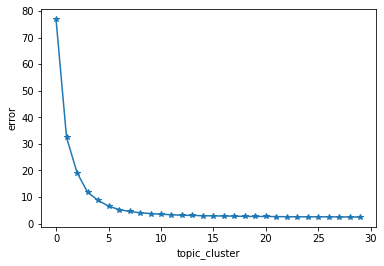

In [84]:
# SSE 是所有样本的聚类误差，代表了聚类效果的好坏，sse_error_list 存放每次结果的误差平方和
sse_error_list = list()
# 设置最大的聚类中心点个数

cluster_max = 30
# 实时显示聚类训练的情况

for clusters in tqdm(range(1, cluster_max + 1)):
    # 构造聚类器，只改变聚类个数，其余均使用默认配置
    clf = KMeans(n_clusters=clusters)
    # 开始训练模型
    clf.fit(word_vector)
    sse_error_list.append(clf.inertia_)

# 横坐标表示聚类个数
plt.xlabel('topic_cluster')

# 纵坐标表示误差
plt.ylabel('error')

# 对聚类点进行显示设置
plt.plot(sse_error_list, '*-')

# 对聚类结果进行可视化
plt.show()

In [85]:
sse_error_mean = sum(sse_error_list) / len(sse_error_list)
sse_error_mean

7.651594662666321

In [86]:
# 定义处理函数
def get_best_clusters(sse_error_list):
    # 通过均值来判断肘部的点,index 从 0 开始
    for index, value in enumerate(sse_error_list):
        if sse_error_mean > value:
            # 返回不超过均值点的下一个聚类索引即可
            return index + 2

In [87]:
best_topic_cluster = get_best_clusters(sse_error_list)
best_topic_cluster

7

In [88]:
# 使用最佳的聚类个数初始化模型，其余使用默认设置
clf = KMeans(n_clusters=best_topic_cluster)

In [89]:
topic_cluster_labels = clf.fit_predict(word_vector)

In [90]:
cluster_centers_list = clf.cluster_centers_
len(cluster_centers_list)

7

In [91]:
import numpy as np
# 存储计算的欧式距离
cal_EuclideanDistance = list()

for index, words in tqdm(list(enumerate(words_list))):
    # 取出词的词向量
    words_vec = model.wv[words]
    # 取出词的聚类中心点的向量
    center_vec = cluster_centers_list[topic_cluster_labels[index]]
    # 计算词向量到聚类中心点的欧式距离
    dist = np.sqrt(np.sum(np.square(words_vec - center_vec)))
    cal_EuclideanDistance.append(dist)

  0%|          | 0/2134 [00:00<?, ?it/s]

In [92]:
# 设置 DataFrame 的列名
topic_cluster_data = pd.DataFrame({
    'words': words_list,
    'topic_cluster': topic_cluster_labels,
    'euclidean_distance': cal_EuclideanDistance
})

# 显示前几行数据
topic_cluster_data.head()

,words,topic_cluster,euclidean_distance
0,疫情,3,0.211651
1,新冠,3,0.211651
2,肺炎,6,0.485098
3,病例,6,0.139416
4,防控,6,0.079188


In [93]:
topic_cluster_data['topic_cluster'].unique()

array([3, 6, 1, 2, 5, 4, 0])

In [94]:
#热度评估
topic_cluster_data['topic_cluster'].groupby(
    topic_cluster_data['topic_cluster']).count()

topic_cluster
0     541
1      32
2      70
3       2
4    1269
5     210
6      10
Name: topic_cluster, dtype: int64

In [95]:
# 按照词与中心点的欧式距离进行降序排列
def get_top_cluster_words(topic_cluster_labels, topn=10):
    # 定义主题和主题词的存储结构
    cluster_result = dict()

    # 分别处理每个主题下的主题词并按照主题词与主题中心的欧式距离进行倒序处理
    for topic_cluster_label in topic_cluster_labels:
        topic_select = topic_cluster_data[topic_cluster_data['topic_cluster'] ==
                                          topic_cluster_label].sort_values(
            by=["euclidean_distance"],
            ascending=False)
        # 输出每个主题下的 topn 的主题词
        cluster_result[topic_cluster_label] = topic_select['words'].tolist()[
            :topn]
    return cluster_result

In [96]:
topic_cluster_labels_list = list(range(best_topic_cluster))
topic_cluster_labels_list

[0, 1, 2, 3, 4, 5, 6]

In [97]:
# 设定每一个主题显示 topn 的词语
topn = 10
topic_result = get_top_cluster_words(topic_cluster_labels_list, topn=topn)
# 打印每个主题下的词语
for topic_num, topic_words in topic_result.items():
    print('主题 # {}- 主题词: {}'.format(topic_num, topic_words))

主题 # 0- 主题词: ['历史', '舆论', '趋势', '香港', '床位', '灾难', '纽约', '战疫', '薪资', '复学']
主题 # 1- 主题词: ['抗击', '疫苗', '指挥部', '美国', '最新消息', '新闻', '发布会', '网友', '世界', '市场']
主题 # 2- 主题词: ['冲击', '政策', '习近平', '感染者', '台湾', '国际', '韩国', '首例', '情况', '莫迪']
主题 # 3- 主题词: ['疫情', '新冠']
主题 # 4- 主题词: ['工作组', '浙江省', '军队', '四次会议', '谎言', '李文亮', '宜春', '一家人', '思客', '大占率']
主题 # 5- 主题词: ['免费', '日增', '传染', '形势', '康复', '源头', '实际', '康复者', '科技', '常态']
主题 # 6- 主题词: ['肺炎', '全球', '印度', '影响', '患者', '病例', '防控', '工作', '中国', '病毒']
